In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image,display

from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt


## Load the data set

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
print(train.shape)
print(test.shape)

(381109, 12)
(127037, 11)


### Split the dataset

In [3]:
X = train.drop(['Response'], axis = 'columns')
y = train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

full_train = X_train.copy()
full_train['Response'] = y_train

# X_train.drop(['id'], axis = 'columns', inplace=True)
# X_test.drop(['id'], axis = 'columns', inplace=True)
# full_train.drop(['id'], axis = 'columns', inplace=True)

print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)
print("train with response shape: ", full_train.shape)

# train.drop(['id'], axis = 'columns', inplace=True)

train shape:  (304887, 11)
test shape:  (76222, 11)
train with response shape:  (304887, 12)


## Handling Null values

In [5]:
info_df = pd.DataFrame(train.dtypes)
info_df['missing_val'] = train.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / train.shape[0] * 100).round(3)
info_df = info_df.sort_values(by='missing_val_ratio', ascending=False)
info_df.head(15)

,0,missing_val,missing_val_ratio
id,int64,0,0.0
Gender,object,0,0.0
Age,int64,0,0.0
Driving_License,int64,0,0.0
Region_Code,float64,0,0.0
Previously_Insured,int64,0,0.0
Vehicle_Age,object,0,0.0
Vehicle_Damage,object,0,0.0
Annual_Premium,float64,0,0.0
Policy_Sales_Channel,float64,0,0.0


There isn't any missing values in any of the columns

## Understanding column values + looking for outliers 

### Age

In [6]:
train['Age'].describe()

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

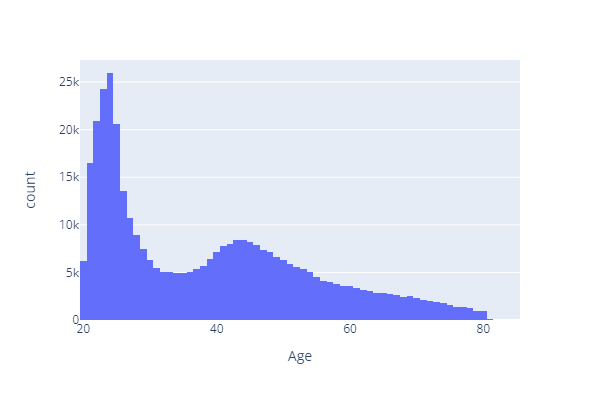

In [7]:
fig = px.histogram(train, x = 'Age', width=600, height=400)
display(Image(fig.to_image(format="png")))

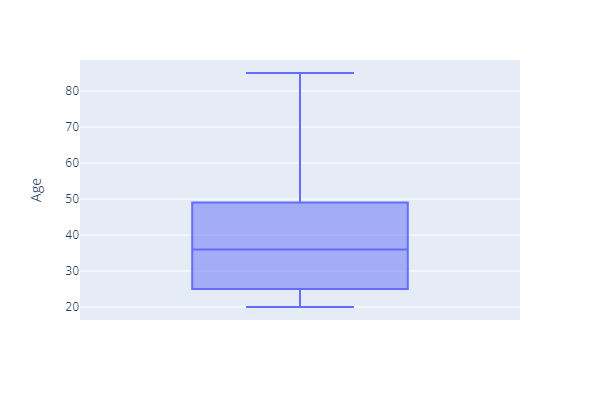

In [8]:
fig = px.box(train, y = 'Age', width=600, height=400)
display(Image(fig.to_image(format="png")))

All age values are in a logical range (20 to 85), there aren't any outliers. We can see that 75% of the age data is less than 50.

### Region_Code

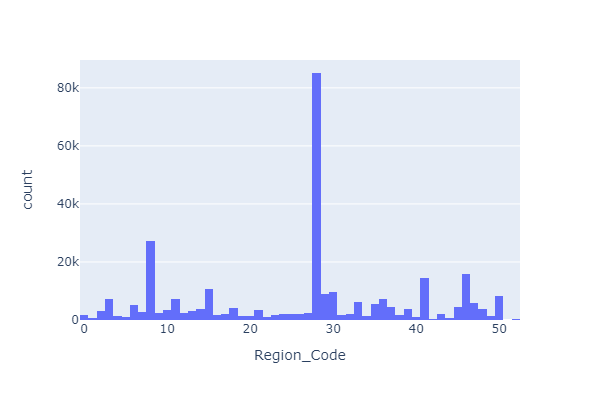

In [4]:
fig = px.histogram(X_train, x = 'Region_Code', width=600, height=400)
display(Image(fig.to_image(format="png")))

Region code 28 has the most counts, followed by region 8.

The regions are in the range from 0 to 52.

### Vehicle_Age

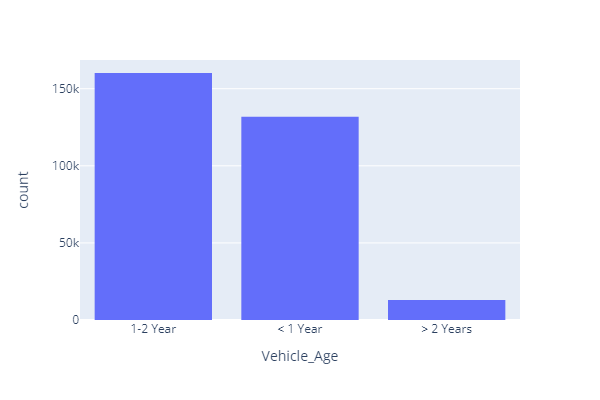

In [9]:
fig = px.histogram(X_train, x = 'Vehicle_Age', width=600, height=400)
display(Image(fig.to_image(format="png")))

Vehicle Age is split into 3 categories, with 1-2 Years being the most freqeunt category

### Vehicle_Damage

In [10]:
X_train['Vehicle_Damage'].value_counts()

Yes    154005
No     150882
Name: Vehicle_Damage, dtype: int64

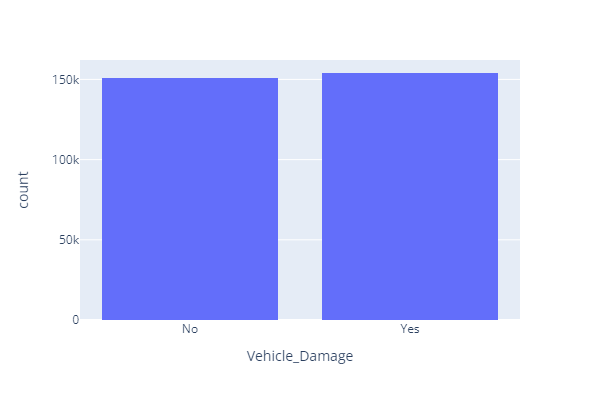

In [11]:
fig = px.histogram(X_train, x = 'Vehicle_Damage', width=600, height=400)
display(Image(fig.to_image(format="png")))

we will change the values of 'Yes' to 1 and 'No' to 0

In [12]:
X_train.loc[X_train['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
X_train.loc[X_train['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0

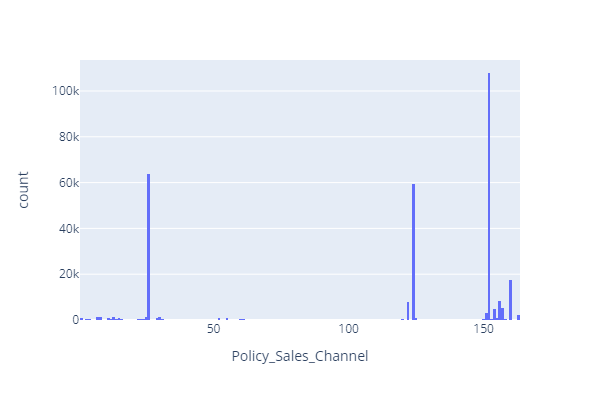

In [13]:
fig = px.histogram(X_train, x = 'Policy_Sales_Channel', width=600, height=400)
display(Image(fig.to_image(format="png")))

In [14]:
X_train['Policy_Sales_Channel'].describe()

count    304887.000000
mean        112.064749
std          54.182115
min           1.000000
25%          29.000000
50%         133.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64

### Vintage

Vintage is the number of days the customer has been associated with the company

In [15]:
X_train['Vintage'].describe()

count    304887.000000
mean        154.328181
std          83.723929
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

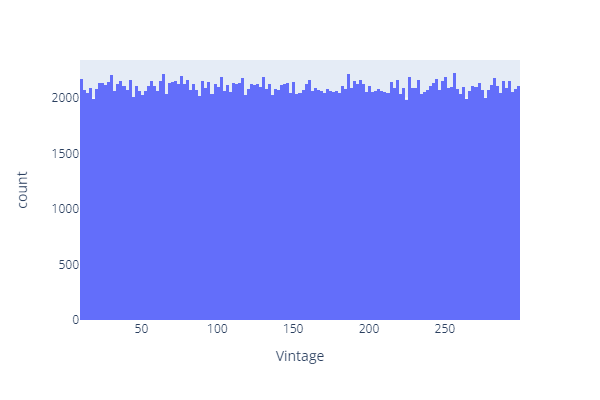

In [16]:
# px.histogram(X_train, x = 'Vintage').show()
fig = px.histogram(X_train, x = 'Vintage', width=600, height=400)
display(Image(fig.to_image(format="png")))

We can notice that all customers have been there for less than one year, and that the customers are evenly distributes over the 299 days

### Annual premium

In [17]:
train['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

We can see that there are values that are way higher than 75% of the data, let's investigate and apply outlier detection methods

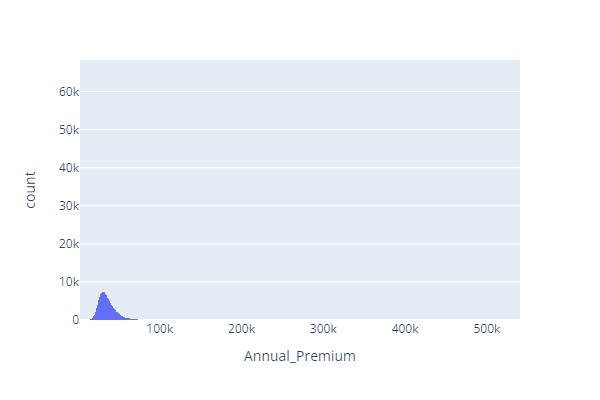

In [18]:
# px.histogram(X_train, x = 'Annual_Premium').show() 
fig = px.histogram(train, x = 'Annual_Premium', width=600, height=400)
display(Image(fig.to_image(format="png")))

The data is following a distribution where the data is skewed to the right, lets flag the values that are 3 std away from the mean as outliers and look into them
 

In [19]:
train_tmp = train.copy()
# train_tmp['Response'] = y_train

def detect_outliers(df, column):
  mean = df[column].mean()
  std = df[column].std()
  upper_bound = mean + 3 * std
  lower_bound = mean - 3 * std
  return df[(df[column] > upper_bound) | (df[column] < lower_bound)][column]

train_tmp['is_outlier_1'] = detect_outliers(train_tmp, 'Annual_Premium')
train_tmp['is_outlier_1'] = train_tmp['is_outlier_1'].apply(lambda x: 0 if np.isnan(x) else 1)

Let's try and explain why these values are outliers

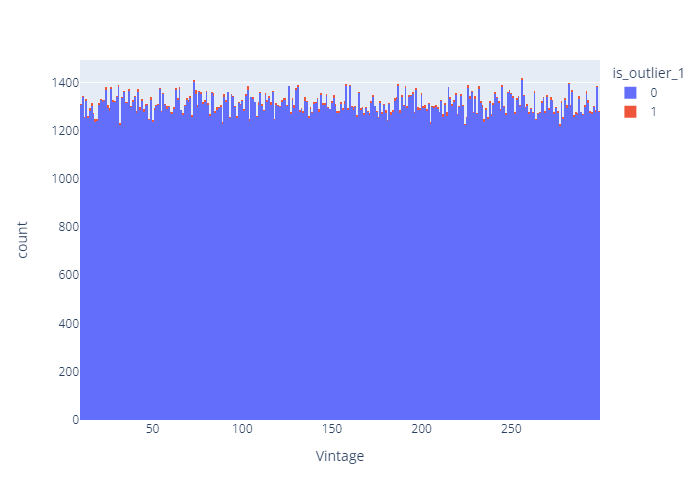

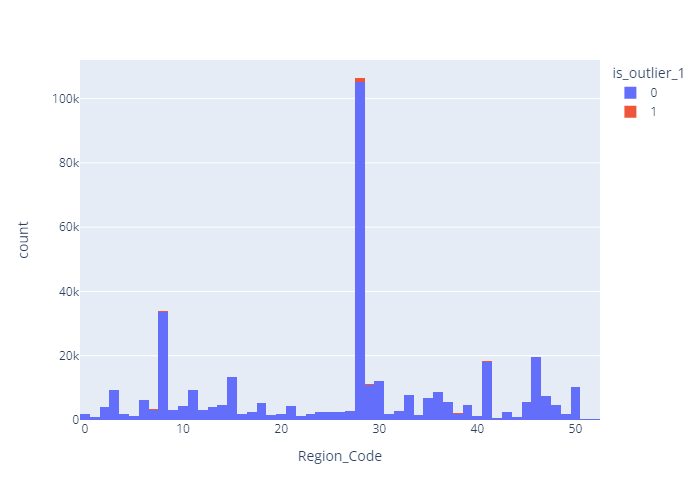

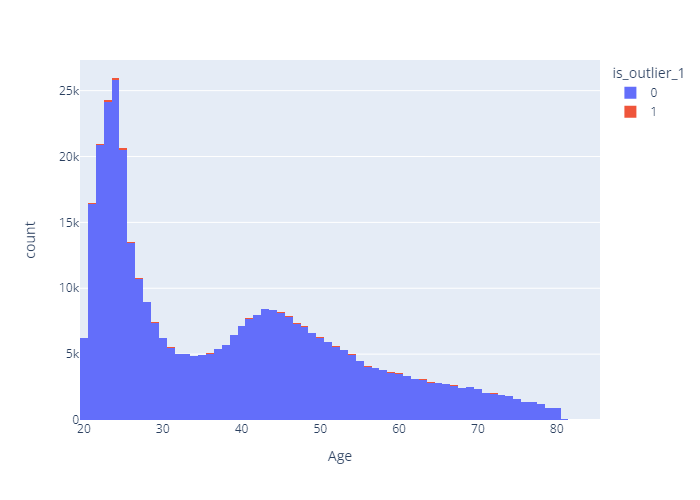

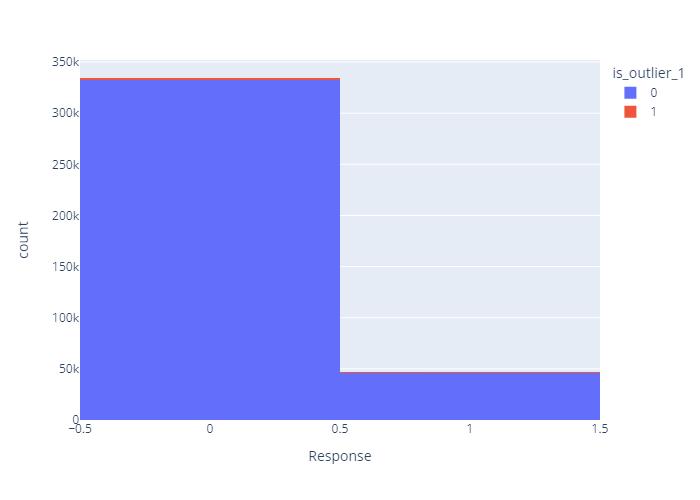

In [20]:
display(Image(px.histogram(train_tmp, x = 'Vintage', color = 'is_outlier_1').to_image(format="png")))
display(Image(px.histogram(train_tmp, x = 'Region_Code', color = 'is_outlier_1').to_image(format="png")))
display(Image(px.histogram(train_tmp, x = 'Age', color = 'is_outlier_1').to_image(format="png")))
display(Image(px.histogram(train_tmp, x = 'Response', color = 'is_outlier_1').to_image(format="png")))

In [21]:
train_tmp[train_tmp['is_outlier_1'] == 1]['Annual_Premium'].describe()

count      2083.000000
mean     110947.000000
std       53736.087822
min       82204.000000
25%       87272.000000
50%       94516.000000
75%      108750.500000
max      540165.000000
Name: Annual_Premium, dtype: float64

In [22]:
train['is_outlier'] = train_tmp['is_outlier_1']
train = train[train['is_outlier'] == 0 ]
train.to_csv('no_outiers_with_month.csv')


In [23]:
train.drop(['is_outlier'], axis='columns', inplace = True)

In [24]:
train.shape

(379026, 12)

when looking at the charts we find that the outliers are distributed in the same way as the normal values when projecting them on other features.
The outliers are all the records where the Annual Premium values is more that 82k.
Since we can't explain why they are outliers, and as the values are definitely high we can either drop them or later se scaling to endure that these values won't skew the performance of the prediction algorithm.


## Adding features

We will convert the Vintage attribute to a new attribute Vintage_month for which it will describe the number of month the customer has been associated with the company (we will divide vintage by 30.44(average number of days in a mont))

In [25]:
train['Vintage_months'] = train['Vintage'] // 30.44

In [26]:
train['Vintage_months'].value_counts()

2.0    32954
4.0    32679
6.0    32559
8.0    31636
3.0    31613
1.0    31498
7.0    31473
5.0    31159
9.0    27245
0.0    22071
Name: Vintage_months, dtype: int64

The reason behind this change is because we think that the model shouldn't trally focus on the number of exact days the customer has been associated with company but rather focus on the their time being there on a higher level.
This is just an assumption that it will make the model generalize better, we will test that later.
 

## Data transformation

In [27]:
categorical_columns = ["Gender","Vehicle_Damage","Vehicle_Age"]


encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(full_train[categorical_columns]))

encoded_df.index = full_train.index

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)


full_train.drop(columns=categorical_columns, inplace=True)

full_train_transformed = pd.concat([full_train, encoded_df], axis=1)

print(full_train_transformed.shape)
full_train_transformed.head()


(304887, 13)


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
135702,135703,45,1,28.0,1,38572.0,124.0,112,0,0.0,0.0,0.0,0.0
99684,99685,23,1,39.0,1,32497.0,152.0,131,0,1.0,0.0,1.0,0.0
47099,47100,44,1,46.0,0,25113.0,26.0,169,0,0.0,1.0,0.0,0.0
359154,359155,23,1,41.0,0,39038.0,152.0,259,0,0.0,1.0,1.0,0.0
21795,21796,44,1,8.0,1,27164.0,26.0,130,0,1.0,0.0,0.0,0.0


## Exploratory Data Analysis

In [29]:
numerical_columns=['Age','Annual_Premium','Vintage']
categorical_columns=['Region_Code','Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage','Response','Policy_Sales_Channel']

### Count of Gender by Response

In [30]:
data = train.groupby(['Gender', 'Response'])['id'].count().reset_index()
data.rename(columns={'id': 'count'}, inplace=True)

fig = px.bar(data, x='Gender', y='count', color='Gender', facet_col='Response', 
             title='Count of Gender by Response', height=400, width=800)

fig.show()

### Count of Driving Licenses by Gender

In [31]:
train.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()

,Gender,Driving_License
0,Female,174111
1,Male,204915


In [32]:
train['Driving_License'].value_counts()

1    378222
0       804
Name: Driving_License, dtype: int64

In [33]:
data = train.groupby(['Gender', 'Driving_License']).size().reset_index(name='count')

data['Driving_License'] = data['Driving_License'].map({0: 'No', 1: 'Yes'})

fig = px.bar(data, x='Gender', y='count', color='Driving_License',
             title='Count of Driving Licenses by Gender', height=400, width=600,
             barmode='group')

fig.show()

### Count of Vehicle Age by Response

In [34]:
train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

,Vehicle_Age,Response,count
0,1-2 Year,0,164556
1,1-2 Year,1,34571
2,< 1 Year,0,156871
3,< 1 Year,1,7171
4,> 2 Years,0,11211
5,> 2 Years,1,4646


In [35]:
data = train.groupby(['Vehicle_Age', 'Response'])['id'].count().reset_index()
data.rename(columns={'id': 'count'}, inplace=True)

fig = px.bar(data, x='Vehicle_Age', y='count', color='Vehicle_Age', facet_col='Response', 
             title='Count of Vehicle Age by Response', height=400, width=800)

fig.show()

### Count of Vehicle Damage by Response

In [36]:
train.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

,Vehicle_Damage,Response,count
0,No,0,186752
1,No,1,978
2,Yes,0,145886
3,Yes,1,45410


In [37]:
data = train.groupby(['Vehicle_Damage', 'Response'])['id'].count().reset_index()
data.rename(columns={'id': 'count'}, inplace=True)

fig = px.bar(data, x='Vehicle_Damage', y='count', color='Vehicle_Damage', facet_col='Response', 
             title='Count of Vehicle Damage by Response', height=400, width=800)

fig.show()

### Count of Age by Response

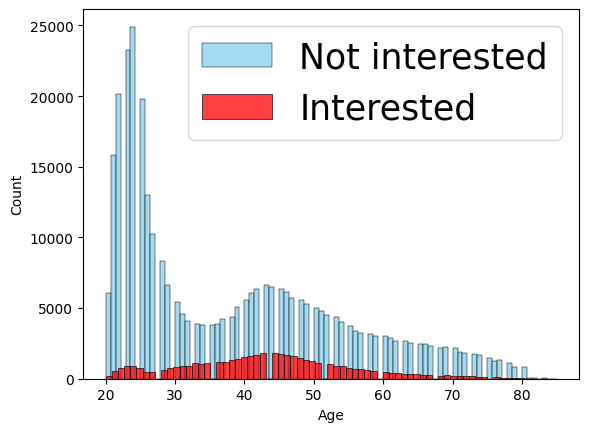

In [42]:
aux10 = train.loc[train['Response'] == 0, 'Age']
aux11 = train.loc[train['Response'] == 1, 'Age']

sns.histplot(data=aux10, color="skyblue", label="Not interested", kde=False)
sns.histplot(data=aux11, color="red", label="Interested", kde=False)
plt.legend(fontsize=25)
plt.show()

### Density of Region_Code by Response

<Axes: xlabel='Region_Code', ylabel='Density'>

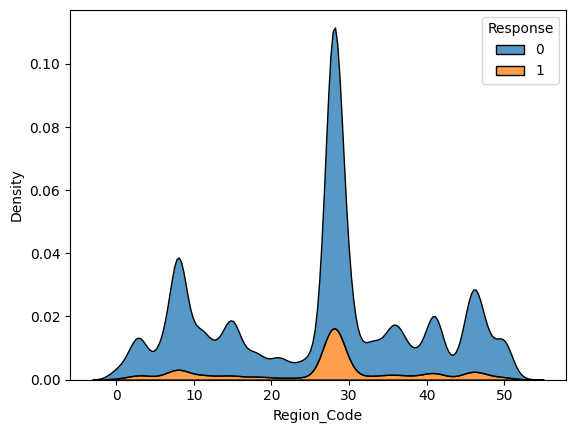

In [43]:
sns.kdeplot(x='Region_Code',data=train,hue='Response', multiple='stack')

### Count of Annual_Premium by Response

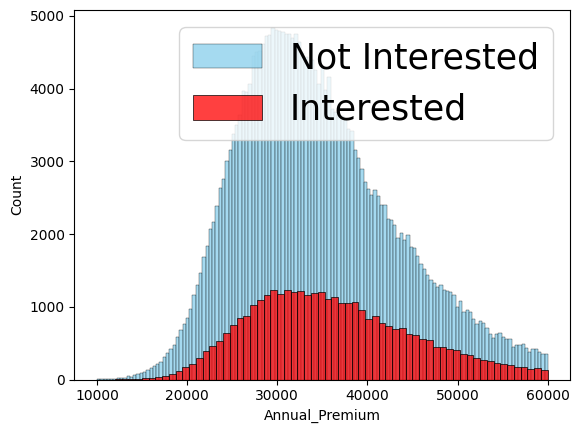

In [44]:
aux70 = train[(train['Annual_Premium'] > 10_000) & (train['Annual_Premium'] < 60_000)]
aux71 = aux70.loc[aux70['Response'] == 0, 'Annual_Premium']
aux72 = aux70.loc[aux70['Response'] == 1, 'Annual_Premium']

sns.histplot(data=aux71, color='skyblue', label="Not Interested")
sns.histplot(data=aux72, color='red', label="Interested")
plt.legend(fontsize=25)
plt.show()

### Density of Vintage by Response

<Axes: xlabel='Vintage', ylabel='Density'>

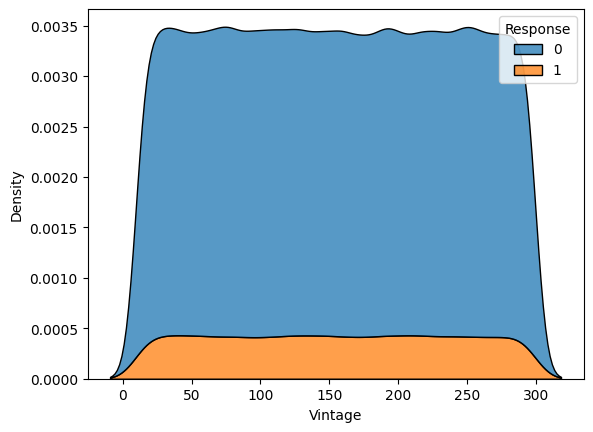

In [45]:
sns.kdeplot(x='Vintage',data=train,hue='Response',multiple='stack')

### Percentage of Interested Customers by Previously Insured Status

In [46]:
table_perc = train.groupby('Response')['Previously_Insured'].value_counts(normalize=True, sort=False) * 100
table_perc = table_perc.reset_index(name="percentage")

fig = go.Figure()

for response, color in zip(table_perc['Response'].unique(), ['red', 'green']):
    df_response = table_perc[table_perc['Response'] == response]
    fig.add_trace(go.Bar(
        x=df_response['Previously_Insured'],
        y=df_response['percentage'],
        name='Interested' if response == 1 else 'Not Interested',
        marker_color=color
    ))

fig.update_layout(
    title='Percentage of Interested Customers by Previously Insured Status',
    xaxis=dict(title='Previously Insured'),
    yaxis=dict(title='Interested Customers (%)'),
    barmode='group'
)

fig.show()

### Age vs Annual Premium with Linear Fit

c:\Users\Yassin52\myenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



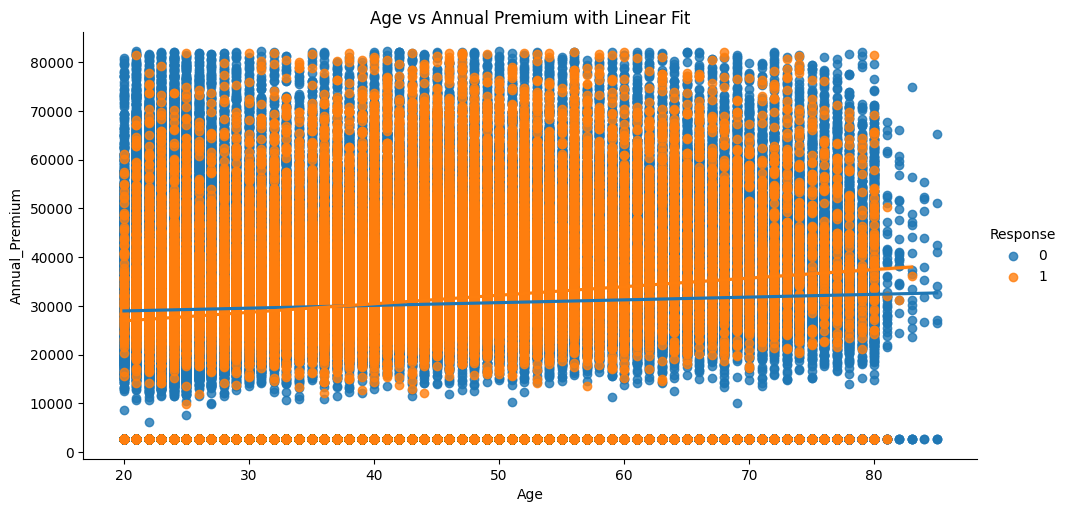

In [47]:
sns.lmplot(x='Age', y='Annual_Premium', data=train, hue='Response', aspect=2)
plt.title('Age vs Annual Premium with Linear Fit')
plt.show()


### Count of Policy Sales Channels by Age

In [48]:
data = train.groupby(['Policy_Sales_Channel', 'Age']).size().reset_index(name='count')

fig = px.bar(data, x='Policy_Sales_Channel', y='count', color='Age',
             title='Count of Policy Sales Channels by Age', height=500, width=700,
             barmode='group')

fig.show()

## Clustering the data

### K-means

In [11]:
scores = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(full_train_transformed)
    scores.append([k, kmeans.score(full_train_transformed)])

scores = pd.DataFrame(scores, columns=('cluster', 'score'))
scores.head()

,cluster,score
0,1,-7.468333e+13
1,2,-2.685764e+13
2,3,-9.941565e+12
3,4,-5.143510e+12
4,5,-3.085061e+12


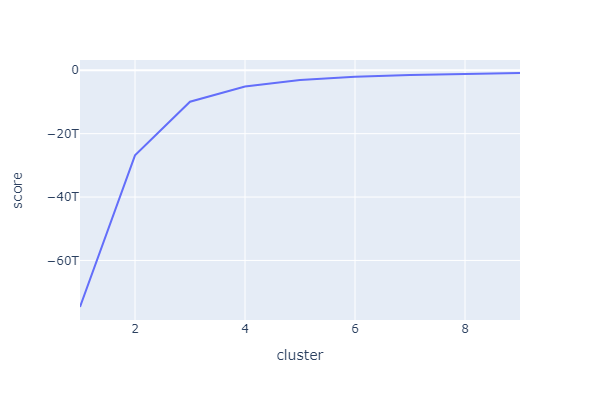

In [12]:
fig = px.line(scores, x="cluster", y="score", width=600, height=400)
display(Image(fig.to_image(format="png")))

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init='auto')
kmeans.fit_predict(full_train_transformed)
kmeans_y_pred = pd.Series(kmeans.predict(full_train_transformed))

In [14]:
kmeans_y_pred_np = np.array(kmeans_y_pred)
print(kmeans_y_pred_np.shape)


unique_vals, counts = np.unique(kmeans_y_pred_np, return_counts=True)
print(unique_vals)
print(counts)

(303220,)
[0 1 2]
[ 72281  52800 178139]


### HDBSCAN

In [15]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(full_train_transformed)
cluster_labels

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [16]:
unique_vals, counts = np.unique(cluster_labels, return_counts=True)
print(unique_vals)
print(counts)

[-1  0  1  2  3  4]
[   765  13491  38287    250    282 250145]


### Assiging label to original df

In [17]:
full_train_transformed['K_means_segments'] = kmeans_y_pred_np
full_train_transformed['hdbscan_segments'] = cluster_labels

## Analyzing clusters

### K-means

#### Visual explanation

In [18]:
counts = full_train_transformed['K_means_segments'].value_counts()
percentages = counts / counts.sum() * 100

tmp = np.array(percentages.index) + 1
print(tmp)

# Convert to a DataFrame for Plotly express
df_percentages = pd.DataFrame({'category': tmp, 'percentage': percentages.values})

df_percentages

[3 1 2]


,category,percentage
0,3,58.749093
1,1,23.837808
2,2,17.413099


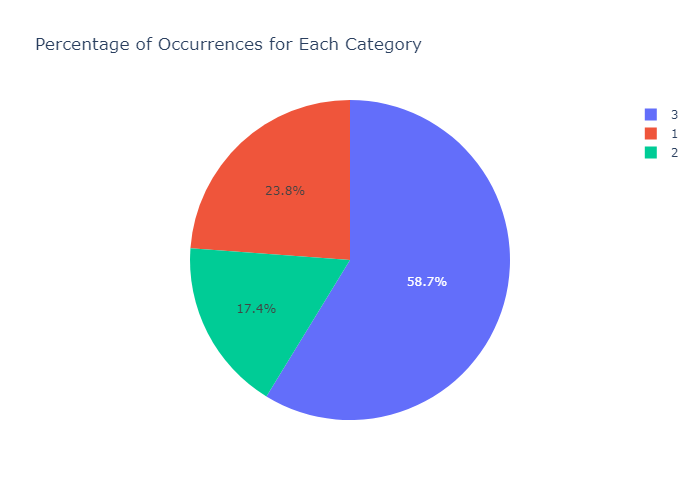

In [19]:
# Create a pie chart using Plotly express
fig = px.pie(df_percentages, values='percentage', names='category', 
             title='Percentage of Occurrences for Each Category')
display(Image(fig.to_image(format="png")))

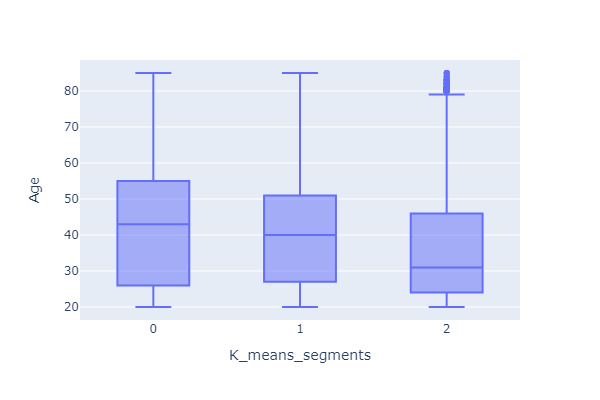

In [20]:
fig = px.box(full_train_transformed,
             x="K_means_segments", y="Age",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

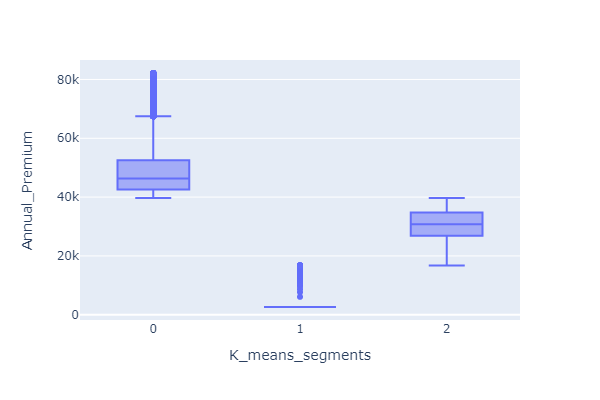

In [21]:
fig = px.box(full_train_transformed,
             x="K_means_segments", y="Annual_Premium",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

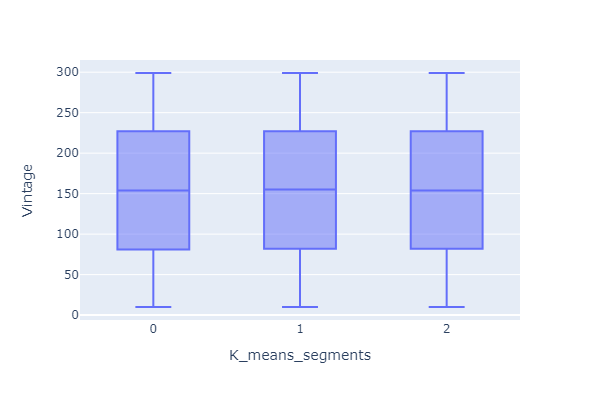

In [22]:
fig = px.box(full_train_transformed,
             x="K_means_segments", y="Vintage",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

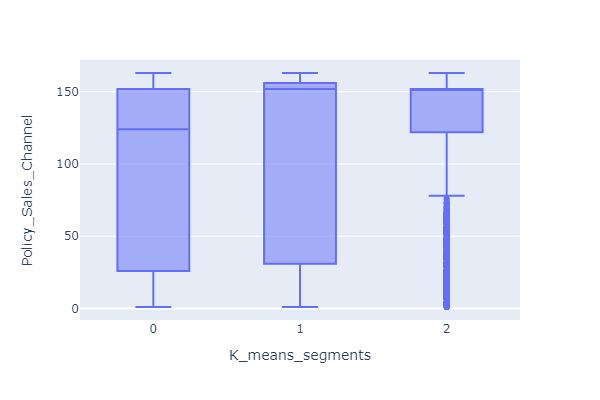

In [23]:
fig = px.box(full_train_transformed,
             x="K_means_segments", y="Policy_Sales_Channel",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

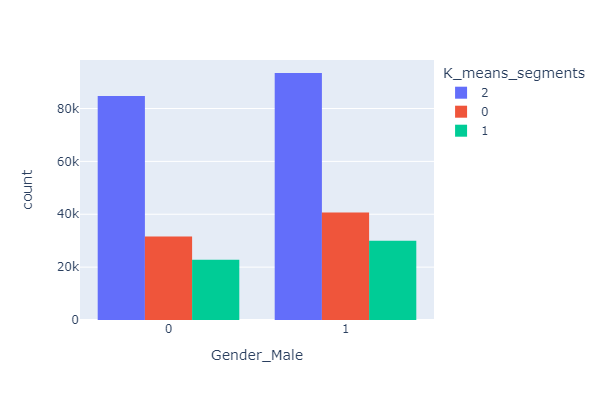

In [24]:
fig = px.histogram(full_train_transformed, x='Gender_Male', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

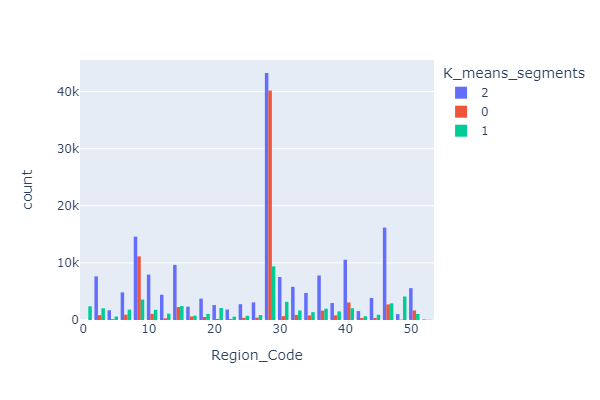

In [25]:
fig = px.histogram(full_train_transformed, x='Region_Code', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=52)
display(Image(fig.to_image(format="png")))

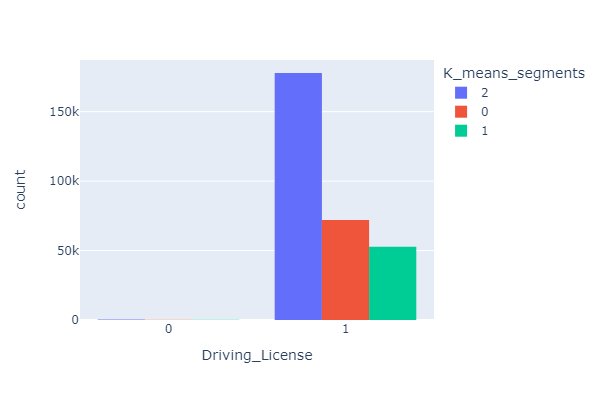

In [26]:
fig = px.histogram(full_train_transformed, x='Driving_License', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

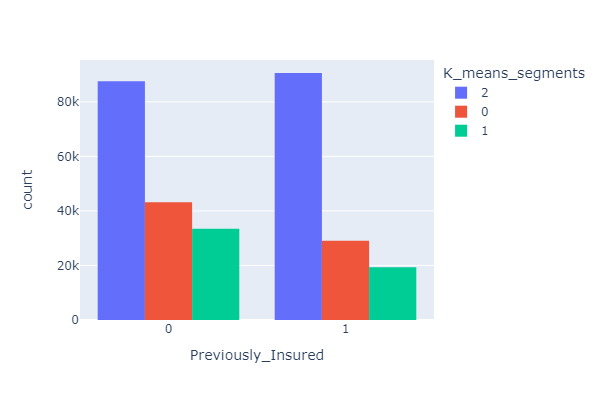

In [27]:
fig = px.histogram(full_train_transformed, x='Previously_Insured', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

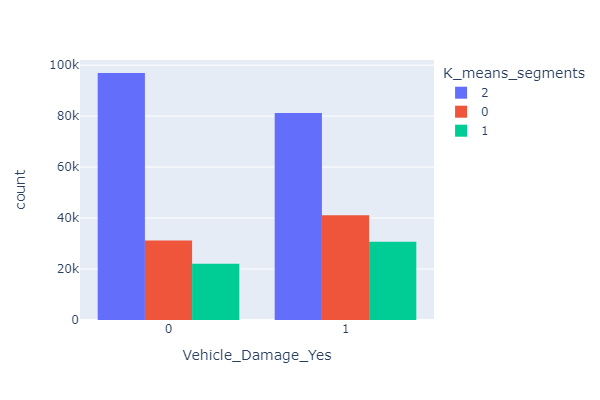

In [28]:
fig = px.histogram(full_train_transformed, x='Vehicle_Damage_Yes', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

In [ ]:
tmp = full_train_transformed[['Vehicle_Age_< 1 Year','Vehicle_Age_> 2 Years','K_means_segments']]
def determine_vehicle_age(row):
    if row['Vehicle_Age_< 1 Year'] == 1:
        return "<1 year"
    elif row['Vehicle_Age_> 2 Years'] == 1:
        return ">2 years"
    else:
        return "1-2 years"

tmp['Vehicle_Age_Category'] = tmp.apply(determine_vehicle_age, axis=1)

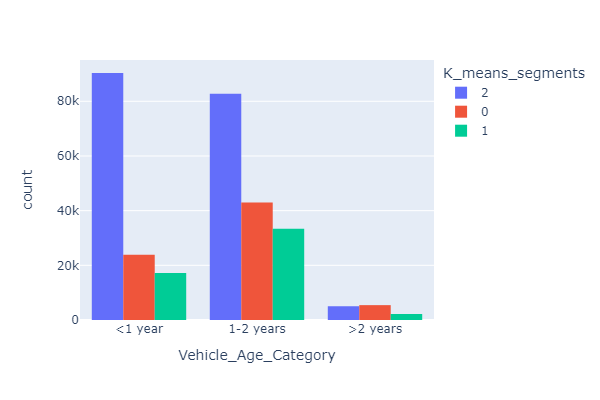

In [30]:
fig = px.histogram(tmp, x='Vehicle_Age_Category', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

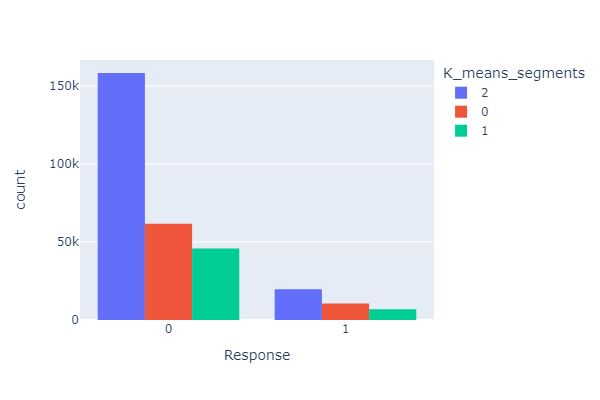

In [31]:
fig = px.histogram(full_train_transformed, x='Response', color='K_means_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

The most influental column in the segmentation is annual_premium column and they are seperated as follows:

0: ranging from 3640 to 17.12k

1: 17.14k -> 41.9k

2: 41.9k -> 540k

Whilst the other columns didnt show any significance contribution to the segmentation.

#### Using a model

In [32]:
X = full_train_transformed.drop(['K_means_segments', 'hdbscan_segments'], axis = 1)
K_means_labels = full_train_transformed['K_means_segments'] 

# Train a random forest classifier on the clustering labels
rf = RandomForestClassifier()
rf.fit(X, K_means_labels)

# Compute feature importance
feature_importances = rf.feature_importances_



# Display feature importance
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# print(importance_df)
importance_df.head(10)

,feature,importance
4,Annual_Premium,0.920854
5,Policy_Sales_Channel,0.029348
2,Region_Code,0.024774
0,Age,0.010219
10,Vehicle_Age_< 1 Year,0.006645
6,Vintage,0.003105
3,Previously_Insured,0.002282
9,Vehicle_Damage_Yes,0.001401
11,Vehicle_Age_> 2 Years,0.000709
8,Gender_Male,0.000348


This bakcs up our claims made from the visualization, with Annual_Premium being the most important feature in classifying.

### HDBSCAN

#### Visual explanation

In [33]:
counts = full_train_transformed['hdbscan_segments'].value_counts()
percentages = counts / counts.sum() * 100

tmp = np.array(percentages.index) + 1
print(tmp)
# Convert to a DataFrame for Plotly express
df_percentages = pd.DataFrame({'category': tmp, 'percentage': percentages.values})

df_percentages

[5 2 1 0 4 3]


,category,percentage
0,5,82.496207
1,2,12.626806
2,1,4.449245
3,0,0.252292
4,4,0.093002
5,3,0.082448


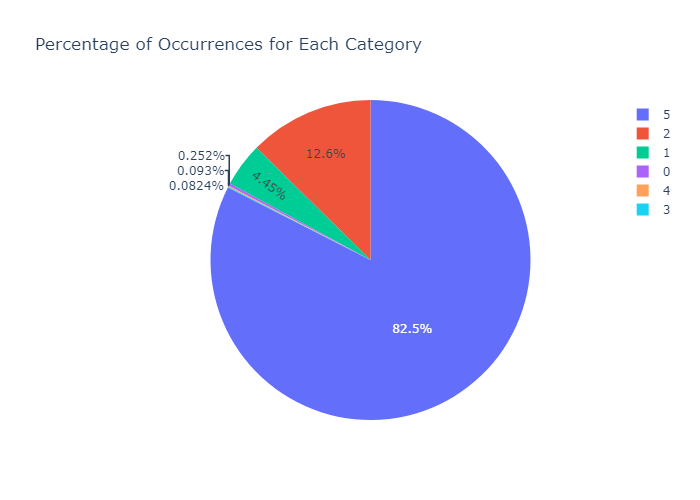

In [34]:
fig = px.pie(df_percentages, values='percentage', names='category', 
             title='Percentage of Occurrences for Each Category')
display(Image(fig.to_image(format="png")))

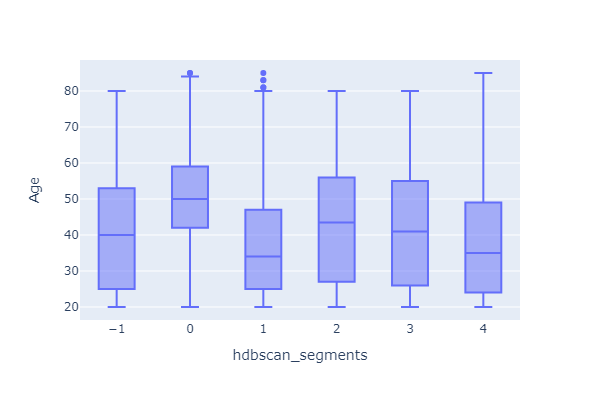

In [35]:
fig = px.box(full_train_transformed,
             x="hdbscan_segments", y="Age",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

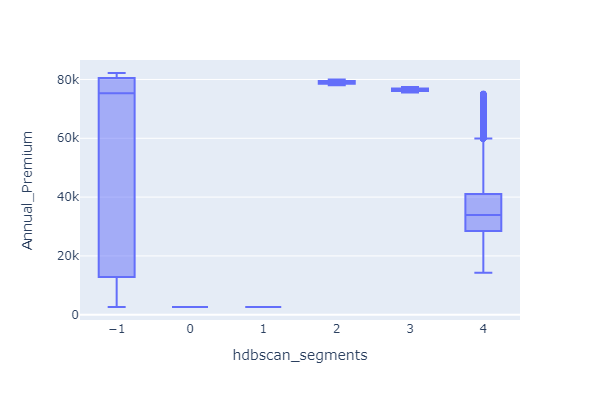

In [36]:
fig = px.box(full_train_transformed,
             x="hdbscan_segments", y="Annual_Premium",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

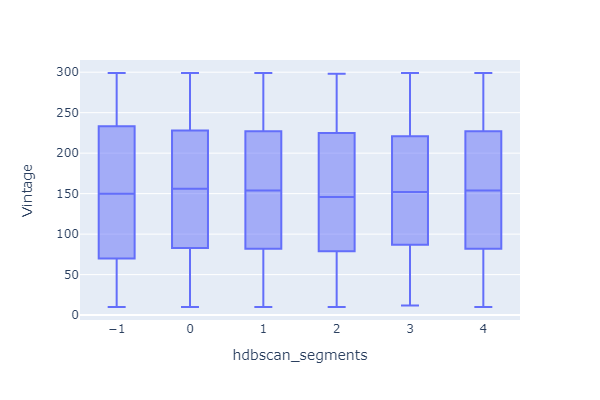

In [37]:
fig = px.box(full_train_transformed,
             x="hdbscan_segments", y="Vintage",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

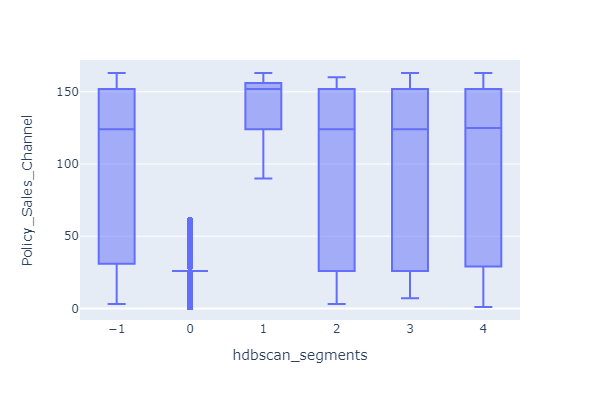

In [38]:
fig = px.box(full_train_transformed,
             x="hdbscan_segments", y="Policy_Sales_Channel",
             width=600, height=400)
display(Image(fig.to_image(format="png")))

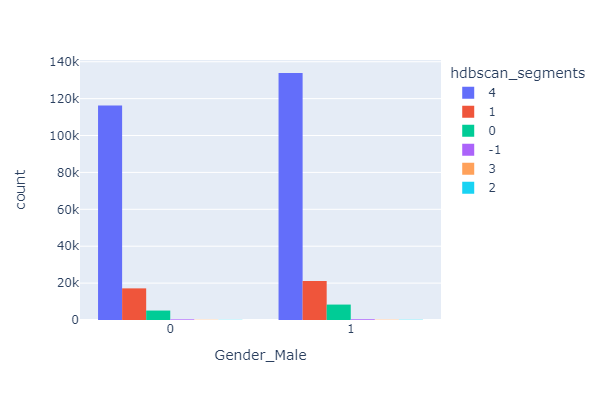

In [39]:
fig = px.histogram(full_train_transformed, x='Gender_Male', color='hdbscan_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

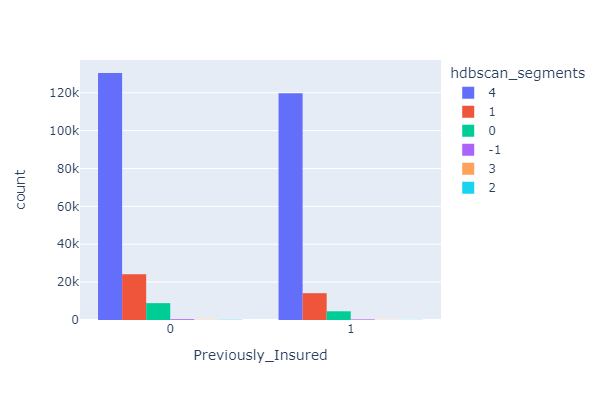

In [40]:
fig = px.histogram(full_train_transformed, x='Previously_Insured', color='hdbscan_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

In [ ]:
tmp = full_train_transformed[['Vehicle_Age_< 1 Year','Vehicle_Age_> 2 Years','hdbscan_segments']]
def determine_vehicle_age(row):
    if row['Vehicle_Age_< 1 Year'] == 1:
        return "<1 year"
    elif row['Vehicle_Age_> 2 Years'] == 1:
        return ">2 years"
    else:
        return "1-2 years"

tmp['Vehicle_Age_Category'] = tmp.apply(determine_vehicle_age, axis=1)

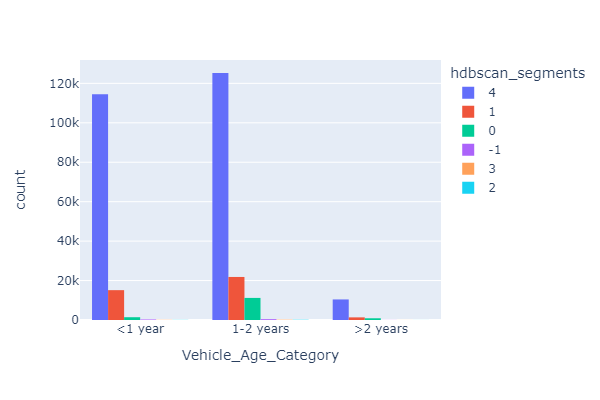

In [42]:
fig = px.histogram(tmp, x='Vehicle_Age_Category', color='hdbscan_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

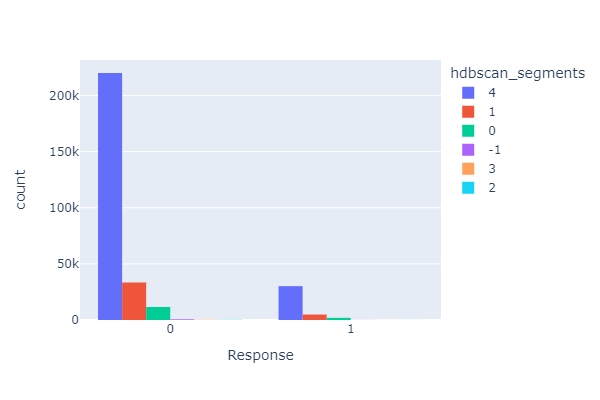

In [43]:
fig = px.histogram(full_train_transformed, x='Response', color='hdbscan_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

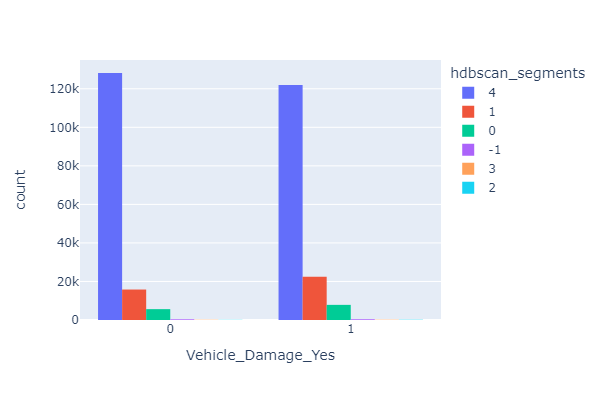

In [44]:
fig = px.histogram(full_train_transformed, x='Vehicle_Damage_Yes', color='hdbscan_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

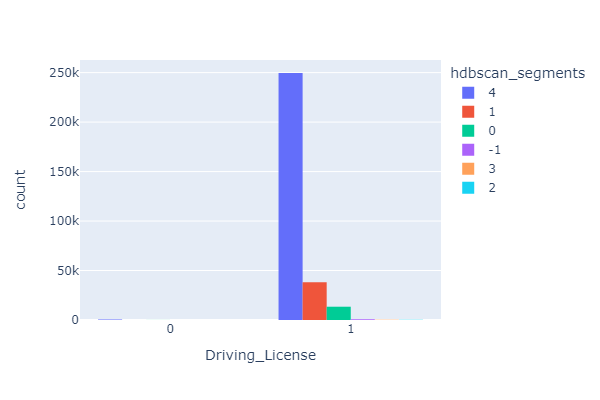

In [45]:
fig = px.histogram(full_train_transformed, x='Driving_License', color='hdbscan_segments', height=400, width=600,
                   barmode='group', nbins=2)
display(Image(fig.to_image(format="png")))

We can see from the charts that the biggest distinction between the segments is in the ranges of the annual_premium,
with the outliers (-1) having the highest values, and then the segment 0 has the second highest values. Segment 1 and 2 have similar values and they are both little.

The segments are also influenced by the Poicy_Sales_channel columns where in segment 1 the channels are on the smaller number side and in 2 the number of the channels are higher. In -1 and 0 thery are dispersed.

#### Using a model

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


# Assume X is your data and hdbscan_labels are the labels from HDBSCAN clustering
X = full_train_transformed.drop(['K_means_segments', 'hdbscan_segments'], axis = 1)
hdbscan_labels = full_train_transformed['hdbscan_segments'] 

# Train a random forest classifier on the clustering labels
rf = RandomForestClassifier()
rf.fit(X, hdbscan_labels)

# Compute feature importance
feature_importances = rf.feature_importances_



# Display feature importance
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)


                  feature  importance
4          Annual_Premium    0.758239
5    Policy_Sales_Channel    0.189139
2             Region_Code    0.022360
0                     Age    0.016378
10   Vehicle_Age_< 1 Year    0.006114
6                 Vintage    0.003674
3      Previously_Insured    0.001756
9      Vehicle_Damage_Yes    0.001268
8             Gender_Male    0.000437
7                Response    0.000430
11  Vehicle_Age_> 2 Years    0.000164
1         Driving_License    0.000041


This bakcs up our claims made from the visualization, with Annual_Premium being the most important feature in classifying and Plocy_Sales_Channel being the second.

### Analyzing outliers

In [55]:
outliers_df = full_train_transformed.copy()
outliers_df.head()
mask = outliers_df['hdbscan_segments'] == 0

is_outlier  = mask.values.astype(int)

In [56]:
rf = RandomForestClassifier()
rf.fit(outliers_df, is_outlier)

# Compute feature importance
feature_importances = rf.feature_importances_

# Display feature importance
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                  feature  importance
4          Annual_Premium    0.489618
5    Policy_Sales_Channel    0.429170
2             Region_Code    0.033559
0                     Age    0.028865
10   Vehicle_Age_< 1 Year    0.012180
6                 Vintage    0.003006
9      Vehicle_Damage_Yes    0.001188
3      Previously_Insured    0.000991
8             Gender_Male    0.000533
7                Response    0.000438
11  Vehicle_Age_> 2 Years    0.000369
1         Driving_License    0.000084


## Detecting Noisy labels

In [ ]:
X_train.columns

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
135702,Female,45,1,28.0,1,1-2 Year,No,38572.0,124.0,112
99684,Male,23,1,39.0,1,< 1 Year,No,32497.0,152.0,131
47099,Female,44,1,46.0,0,1-2 Year,Yes,25113.0,26.0,169
359154,Female,23,1,41.0,0,< 1 Year,Yes,39038.0,152.0,259
21795,Male,44,1,8.0,1,1-2 Year,No,27164.0,26.0,130


In [ ]:
X = pd.get_dummies(X_train[['Age','Vehicle_Damage','Annual_Premium','Previously_Insured']])
X.head()

,Age,Annual_Premium,Previously_Insured,Vehicle_Damage_No,Vehicle_Damage_Yes
135702,45,38572.0,1,True,False
99684,23,32497.0,1,True,False
47099,44,25113.0,0,False,True
359154,23,39038.0,0,False,True
21795,44,27164.0,1,True,False


In [ ]:
from cleanlab.classification import CleanLearning
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
# This works with any sklearn-compatible model
label_issues_info = CleanLearning(clf=clf).find_label_issues(X, y_train)
label_issues_info

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.999235,0,0
1,False,0.999155,0,0
2,False,0.681510,0,0
3,False,0.873038,0,0
4,False,0.999073,0,0
...,...,...,...,...
304882,False,0.640422,0,0
304883,False,0.772525,0,0
304884,False,0.999221,0,0
304885,False,0.999074,0,0


In [ ]:
label_issues_info[(label_issues_info['is_label_issue'] & (label_issues_info['label_quality'] >= 0.2))]

,is_label_issue,label_quality,given_label,predicted_label
29105,True,0.467302,0,1
103775,True,0.378855,0,1
118122,True,0.493810,0,1
162032,True,0.411817,0,1
169882,True,0.458524,0,1
294656,True,0.464708,0,1


In [ ]:
label_issues_info[label_issues_info['is_label_issue']]['label_quality'].describe()

count    2098.000000
mean        0.073141
std         0.039864
min         0.000463
25%         0.041089
50%         0.078153
75%         0.109904
max         0.493810
Name: label_quality, dtype: float64

In [ ]:
X[(X['is_noisy'] & (X['label_quality'] >= 0.2))]

,Age,Annual_Premium,Previously_Insured,Vehicle_Damage_No,Vehicle_Damage_Yes,is_noisy,label_quality,is_label_issue,given_label,predicted_label
162032,25,29613.0,1,True,False,True,0.411817,True,0.0,1.0
29105,34,43753.0,1,True,False,True,0.467302,True,0.0,1.0
118122,21,2630.0,0,True,False,True,0.493810,True,0.0,1.0
103775,40,32956.0,0,False,True,True,0.378855,True,0.0,1.0


There are four records where its given a label issue and the label quality is over 0.2, we are going to leave them in the database.